In [5]:
# header files
import os
import sys
import glob
import math
from skimage import data, io
from scipy.io import loadmat
import numpy as np
import sys
import numpy.random as ra
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
print("Header files loaded!")

Header files loaded!


In [2]:
# DATA
# BRAIN PHANTOM Images: 256x256, 512x512, 1024x1024, 2048x2048, 4096x4096
# SL PHANTOM Images: 256x256, 512x512, 1024x1024, 2048x2048, 4096x4096

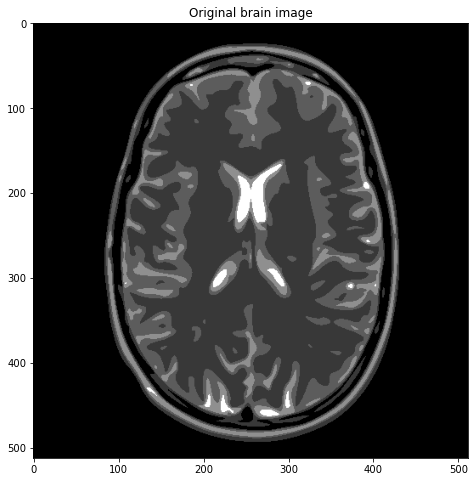

In [3]:
# view image
img_size = 512
FOV = 0.2
pixel_size = FOV/img_size

# load data file corresponding to the target resolution
mri_img = io.imread("../data/BrainPhantom512.png")

plt.figure()
plt.title("Brain Phantom, size = %s " % img_size)
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.title("Original brain image")
plt.show()

In [4]:
# y = Fx + b
# x' = F'y

<Figure size 576x576 with 0 Axes>

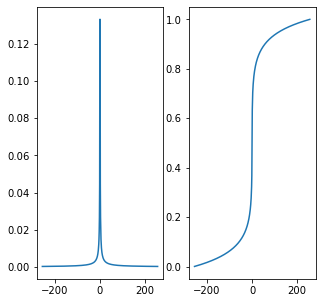

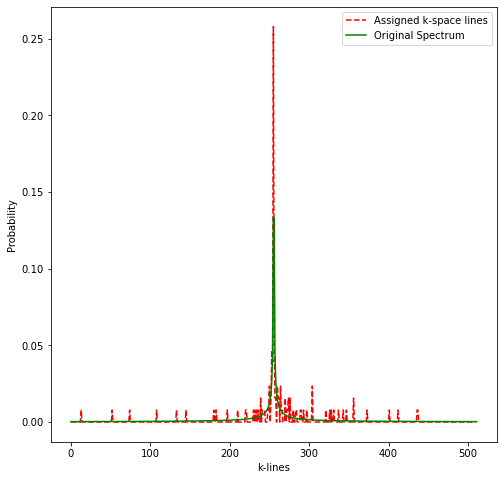

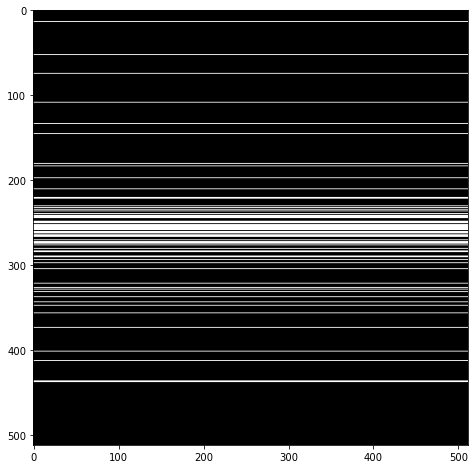

In [8]:
eps = sys.float_info.epsilon
c = np.ones((1, img_size), dtype="float64")
kspace_mask = np.tile(c, (img_size, 1))
kspace_lines = np.linspace(-1/2., 1/2.,img_size)*img_size
decay = 1.

# Define the sampling density
p_decay = np.power(np.abs(kspace_lines),-decay)
p_decay = p_decay/np.sum(p_decay)
cdf_pdecay = np.cumsum(p_decay)
pmax = p_decay.max()
pmin = p_decay.min()

# Plot the density and its cumulative distribution function (CDF) p_decay
plt.figure()
fig, axs = plt.subplots(1, 2, figsize= (5,5) )
axs[0].plot(kspace_lines, p_decay)
axs[1].plot(kspace_lines, cdf_pdecay)

# Perform pseudo-random sampling: technique used:
# draw uniform variables and invert the CDF to get back to p_decay-distributed sampled
nb_samples = (int)(img_size/4)
samples = ra.uniform(0, 1, nb_samples)
gen_klines = [int(kspace_lines[np.argwhere(cdf_pdecay == min(cdf_pdecay[(cdf_pdecay - r) > 0]))]) for r in samples]
gen_klinesb = ((np.array(gen_klines) - 1) / 1).astype(int) + (int)(img_size/2)
times = np.arange(1, img_size, 1)
lc = np.bincount(gen_klinesb, minlength=len(times))

plt.figure()
plot1, = plt.plot(lc/float(sum(lc)), 'r--', label='Assigned k-space lines')
plot2, = plt.plot(p_decay,'g',label='Original Spectrum')
plt.xlabel('k-lines')
plt.ylabel('Probability')
plt.legend(handles=[plot1,plot2])
plt.show()

sampled_klines = np.array(np.unique(gen_klinesb))
nblines = np.size(sampled_klines)
threshold = 2. * p_decay.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask[sampled_klines,:] = np.ones((nblines,img_size) , dtype="float64")

plt.figure()
plt.imshow(kspace_mask, cmap='gray')
plt.show()

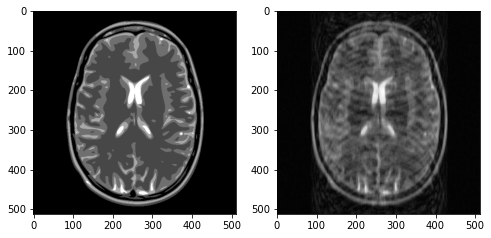

In [9]:
norm = "ortho"
def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

kspace_data = np.fft.fftshift(fft(mri_img))
signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
kspace_data *= kspace_mask
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mri_img, cmap="Greys_r")
ax2.imshow(np.abs(image_rec0), cmap="Greys_r")